<div>
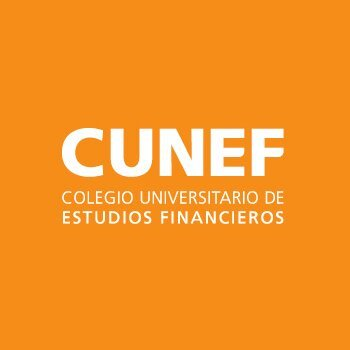
</div>

# **Turismo en España (intervenido)**
En este notebook se mostrará la serie temporal intervenida del **número de turistas en España** y observaremos cómo se comportarían sus pronósticos en el caso de que no hubiera existido COVID-19. 

Estructura del notebook:
    
    1) Librerías utilizadas
    2) Lectura y preprocesado de los datos
    3) EDA (Análisis Exploratorio de Datos)
    4) Elección del modelo predictivo
        4.1) Modelo de suavizado exponencial (ETS)
        4.2) Modelo autorregresivo integrado de media móvil (ARIMA)
        4.3) Modelo FB Prophet
    5) Predicción hasta finales de año 

## *1) Librerías utilizadas*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
from prophet import Prophet
from sktime.forecasting.arima import AutoARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics import tsaplots
from sktime.utils.plotting import plot_correlations
from statsmodels.tsa.seasonal import seasonal_decompose
from sktime.transformations.series.boxcox import LogTransformer
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
from sktime.performance_metrics.forecasting import MeanSquaredError
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.transformations.series.difference import Differencer
from sktime.utils.plotting import plot_series
from sktime.forecasting.ets import AutoETS
warnings.filterwarnings('ignore')

## *2) Lectura del csv y preprocesado de los datos*

Se procede a la lectura del CSV del tráfico de turistas en España.
- Fuente: https://www.ine.es/dyngs/INEbase/es/operacion.htm?c=Estadistica_C&cid=1254736176996&menu=ultiDatos&idp=1254735576863

In [29]:
df = pd.read_csv("turismo.csv", delimiter=";")
df

,Comunidades autónomas,Tipo de dato,Periodo,Total
0,Total,Dato base,2022M06,7.460.277
1,Total,Dato base,2022M05,6.966.913
2,Total,Dato base,2022M04,6.102.142
3,Total,Dato base,2022M03,4.032.127
4,Total,Dato base,2022M02,3.156.809
...,...,...,...,...
2463,Otras Comunidades Autónomas,Tasa de variación acumulada,2016M02,"-3,51"
2464,Otras Comunidades Autónomas,Tasa de variación acumulada,2016M01,"-8,65"
2465,Otras Comunidades Autónomas,Tasa de variación acumulada,2015M12,NaN
2466,Otras Comunidades Autónomas,Tasa de variación acumulada,2015M11,NaN


In [30]:
df_turismo = df.iloc[0:76, 2:5]
# Convertimos en formato fecha
df_turismo['Periodo'] = df_turismo['Periodo'].str.replace('M', '') # para erradicar la M
df_turismo['Periodo'] = pd.to_datetime(df_turismo['Periodo'], format='%Y%m')
# Creación de índice
df_turismo = df_turismo.set_index("Periodo")
# Eliminación del separador "."
df_turismo['Total']=df_turismo['Total'].str.replace('.', '').astype(float)
# Cambio de orden de las fechas
df_turismo=df_turismo.iloc[::-1]
df_turismo

,Total
Periodo,
2016-03-01,4627206.0
2016-04-01,6086327.0
2016-05-01,7111154.0
2016-06-01,7552758.0
2016-07-01,9545792.0
...,...
2022-02-01,3156809.0
2022-03-01,4032127.0
2022-04-01,6102142.0


Vamos a representar gráficamente el conjunto de datos resaltando todo el momento COVID-19 y vamos a ver qué meses son los que más han alterado la predicción:

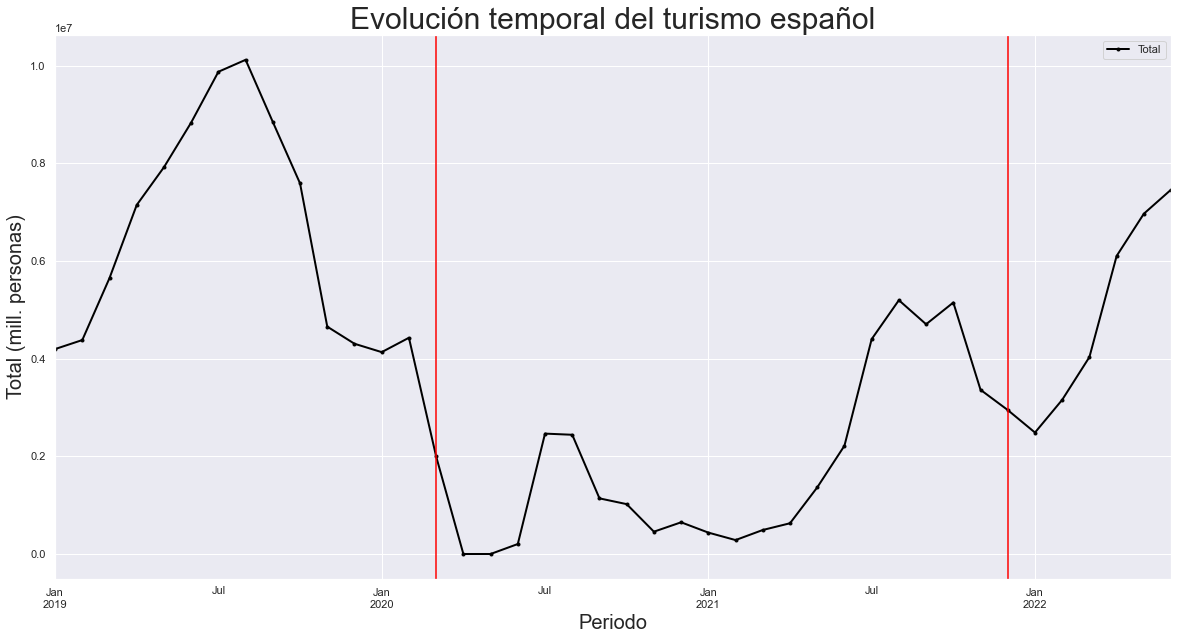

In [31]:
sns.set(rc={'figure.figsize':(20,10)})
fig=df_turismo['2019':].plot(marker='.',color ='black',linewidth= 2)
fig.set_title('Evolución temporal del turismo español',fontsize=30)
fig.set_ylabel('Total (mill. personas)',fontsize=20)
fig.axvline('2020-03-01',color='red',linewidth=1.5)
fig.axvline('2021-12-01', color='red', linewidth=1.5)
fig.set_xlabel('Periodo',fontsize=20);
# fig.figure.savefig('../pics/df_paro_new/beforemanipulation')

Vemos que desde marzo del 2020 hasta noviembre del 2021 son los meses que más datos de desempleo hay por el efecto COVID-19, esto son **20 meses** (incluyendo ambos meses). Vamos a quedarnos con los datos hasta febrero del 2020, justo antes del inicio de la pandemia en nuestro país, y vamos a hacer un entrenamiento-test con autoETS para rellenar los datos hasta noviembre 2021 inclusive. 

**¿Por qué con AutoETS?** Porque se ha comprobado en el análisis anterior que era más preciso que el autoARIMA.

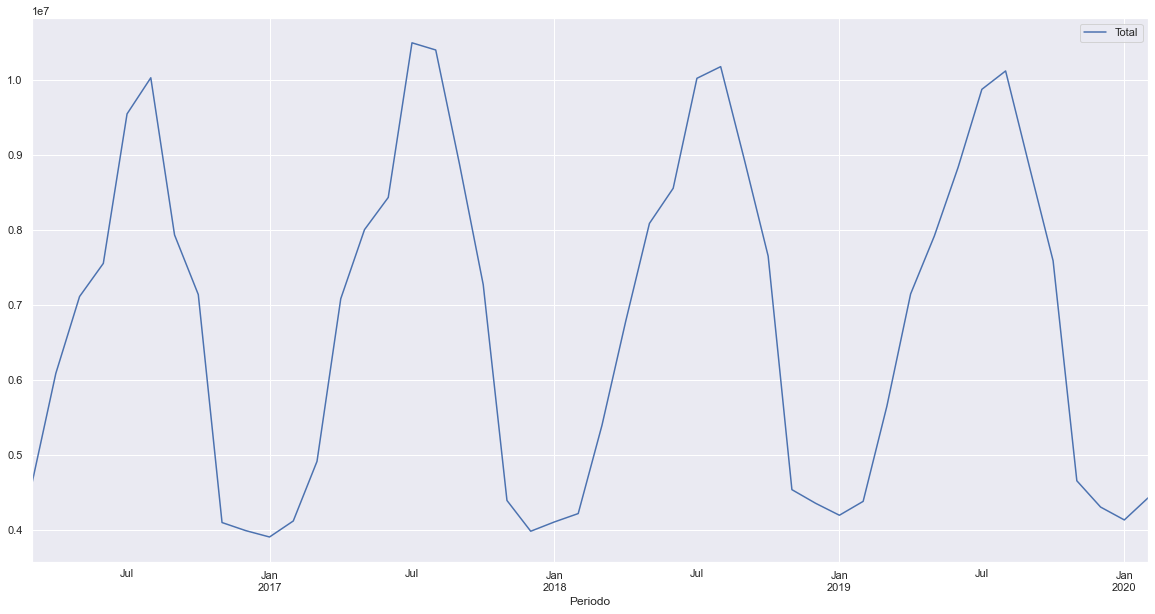

In [32]:
# Nos quedamos de momento con los datos hasta febrero de 2021:
df_turismo2 = df_turismo.loc['2013-02':'2020-02']
# Hacemos la predicción sobre esta time series:
df_turismo2.plot();

Cantidad de períodos en Train: 28
Cantidad de períodos en Test: 20


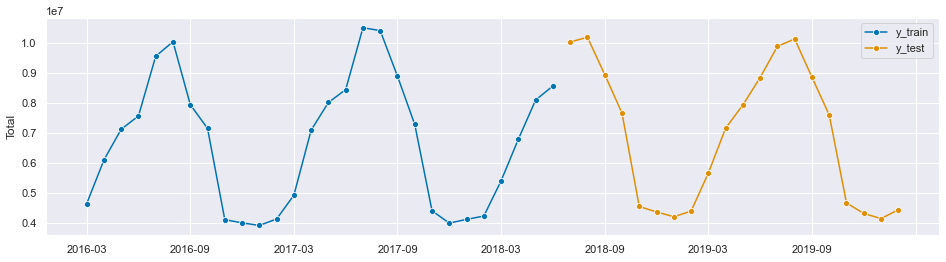

In [33]:
#y_train, y_test
y_train, y_test = temporal_train_test_split(
    y=df_turismo2['Total'].astype('float64').to_period('M'),test_size = 20)
plot_series(y_train, y_test, labels=["y_train","y_test"])
print('Cantidad de períodos en Train:', y_train.shape[0])
print('Cantidad de períodos en Test:', y_test.shape[0])
plt.show()

In [34]:
y_test

2018-07    10020246.0
2018-08    10175761.0
2018-09     8932308.0
2018-10     7649860.0
2018-11     4536873.0
2018-12     4354798.0
2019-01     4195641.0
2019-02     4380504.0
2019-03     5649577.0
2019-04     7146033.0
2019-05     7919204.0
2019-06     8833893.0
2019-07     9873270.0
2019-08    10118366.0
2019-09     8845152.0
2019-10     7587749.0
2019-11     4655021.0
2019-12     4304741.0
2020-01     4133024.0
2020-02     4427344.0
Freq: M, Name: Total, dtype: float64

Aplicamos el modelo AutoETS para que testee el modelo entrenado.

In [35]:
fh = np.arange(1, y_test.shape[0]+1)
turismo_auto_ets=AutoETS(auto=True,sp=12,n_jobs=1)

In [36]:
turismo_auto_ets.fit(y_train)

AutoETS(auto=True, n_jobs=1, sp=12)

In [37]:
turismo_pred = turismo_auto_ets.predict(fh)
turismo_pred.round()

2018-07    10660191.0
2018-08    10833483.0
2018-09     8871077.0
2018-10     7593832.0
2018-11     4450109.0
2018-12     4165676.0
2019-01     4164688.0
2019-02     4311852.0
2019-03     5320406.0
2019-04     7012564.0
2019-05     8116805.0
2019-06     8546831.0
2019-07    10660191.0
2019-08    10833483.0
2019-09     8871077.0
2019-10     7593832.0
2019-11     4450109.0
2019-12     4165676.0
2020-01     4164688.0
2020-02     4311852.0
Freq: M, dtype: float64

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Total'>)

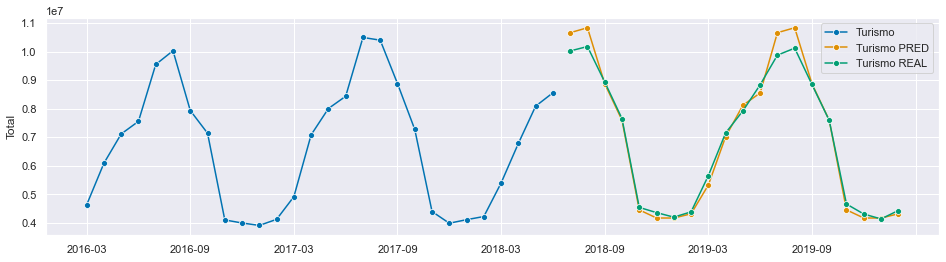

In [38]:
plot_series(y_train, turismo_pred, y_test,labels= ["Turismo", 'Turismo PRED', 'Turismo REAL'],)

El modelo se comporta bien y da una precisión buena, por lo que aplicaremos un horizonte nuevo de predicción y los datos que nos prediga hasta diciembre del 2021 serán los datos con los que vayamos a trabajar para testear los modelos y hacer una posterior predicción hasta finales del 2022.

In [39]:
turismo_ficticio = df_turismo.loc['2016-02': '2020-02']
fh=np.arange(1, 22) # hasta nov2021
df_auto = AutoETS(auto= True, 
                  sp =12, #mensual
                  n_jobs=1)
y = turismo_ficticio.astype('float64').to_period('M')
df_auto.fit(y)
print(df_auto.summary())

                                 ETS Results                                  
Dep. Variable:                      y   No. Observations:                   48
Model:                       ETS(MNM)   Log Likelihood                -677.642
Date:                Thu, 01 Sep 2022   AIC                           1387.284
Time:                        00:02:50   BIC                           1417.223
Sample:                    03-31-2016   HQIC                          1398.598
                         - 02-29-2020   Scale                            0.003
Covariance Type:               approx                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.4073      0.182      2.238      0.025       0.051       0.764
smoothing_seasonal      0.5926      0.317      1.871      0.061      -0.028       1.213
initial_level   

In [40]:
#step 5: querying predictions
turismo_pred = df_auto.predict(fh=list(fh))
turismo_pred.round()

,Total
2020-03,5567266.0
2020-04,7037309.0
2020-05,7993545.0
2020-06,8820595.0
2020-07,10054132.0
2020-08,10423836.0
2020-09,9140573.0
2020-10,7796987.0
2020-11,4690515.0
2020-12,4320861.0


Ya tenemos los datos predichos hasta diciembre-2021, vamos a suprimir los datos del desempleo alterados por la etapa COVID-19 y vamos a usar los datos predecidos por este modelo.

In [41]:
df_turismo_new = df_turismo
df_turismo_new.loc['2020-03-01':'2021-11-01','Total']=['5567266','7037309','7993545','8820595','10054132',
                                                       '10423836','9140573','7796987','4690515','4320861',
                                                       '4165017','4427339','5567266','7037309','7993545',
                                                       '8820595','10054132','10423836','9140573','7796987',
                                                       '4690515']

In [42]:
df_turismo_new

,Total
Periodo,
2016-03-01,4627206.0
2016-04-01,6086327.0
2016-05-01,7111154.0
2016-06-01,7552758.0
2016-07-01,9545792.0
...,...
2022-02-01,3156809.0
2022-03-01,4032127.0
2022-04-01,6102142.0


In [45]:
# hay que pasar los datos de tipo objeto a tipo numérico (float)
df_turismo_new = pd.to_numeric(df_turismo_new['Total'])
df_turismo_new.dtypes

dtype('float64')

Text(0.5, 0, 'Periodo')

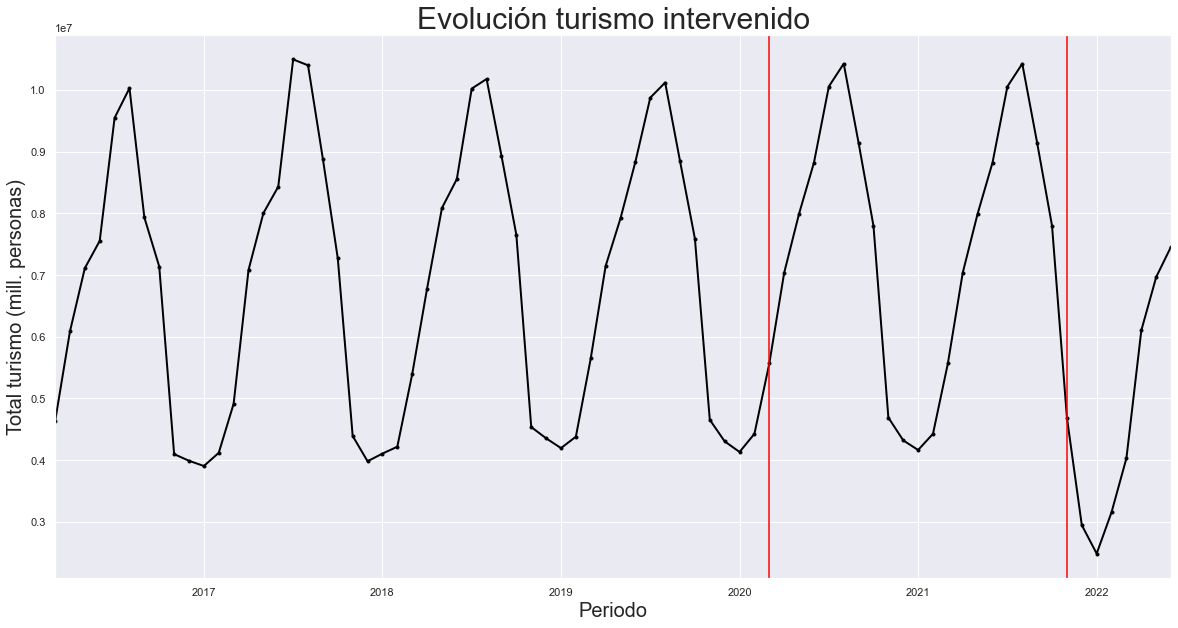

In [50]:
sns.set(rc={'figure.figsize':(20,10)})
fig=df_turismo_new.plot(marker='.',color ='black',linewidth= 2)
fig.set_title('Evolución turismo intervenido',fontsize=30)
fig.set_ylabel('Total turismo (mill. personas)',fontsize=20)
fig.axvline('2020-03-01',color='red',linewidth=1.5)
fig.axvline('2021-11-01', color='red', linewidth=1.5)
fig.set_xlabel('Periodo',fontsize=20)
# fig.figure.savefig('../pics/df_paro_new/aftermanipulation');

Ahora sí que guarda una tendencia y una estacionalidad similar. Vamos a hacer un breve EDA (esta vez con todo el DataFrame al no haber momento atípico por COVID-19) y luego procedemos ahora a predecir la serie temporal con los modelos.

## *3) EDA*

### 3.1) Test de Dickey-Fuller aumentada

Esta prueba nos proporciona una verificación rápida y evidente de si la serie es estacionaria o no.

**La hipótesis nula (H0)** de la prueba es que la serie temporal se puede representar mediante una raíz unitaria, que no es estacionaria, es decir, que tiene alguna estructura dependiente del tiempo. 

**La hipótesis alternativa (H1)**, que rechaza la hipótesis nula, indica que la serie temporal es estacionaria.

Interpretamos este resultado utilizando el p-value. Un valor p por debajo del umbral de significancia (0.05) significa que la hipótesis nula se rechaza.

In [47]:
def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(df_turismo_new)

Results of Dickey-Fuller Test:
Test Statistic                 -0.809314
p-value                         0.816371
#Lags Used                     12.000000
Number of Observations Used    63.000000
Critical Value (1%)            -3.538695
Critical Value (5%)            -2.908645
Critical Value (10%)           -2.591897
dtype: float64


**La serie temporal sigue siendo NO estacionaria**, debido a que el p-value del test Dickey-Fuller (0.81) es mayor que 0.05, y eso indica que se acepta la hipótesis nula (H0).

### 3.2) Comportamiento mensual

Text(0.5, 1.0, 'Comportamiento mensual')

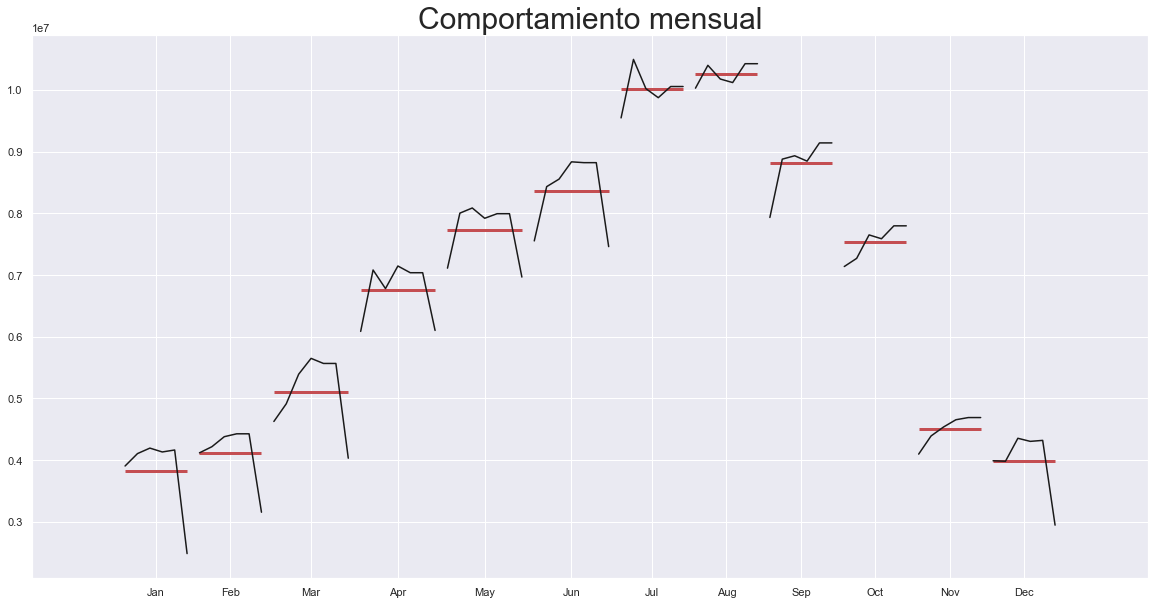

In [48]:
ax=plt.gca() 
sm.graphics.tsa.month_plot(df_turismo_new,ax=ax)
ax.set_title('Comportamiento mensual',fontsize=30)
# fig.figure.savefig('../pics/df_paro_new/monthlybehavior.png');

Sigue cumpliendo con la estacionalidad del desempleo real.

### 3.3) Descomposición

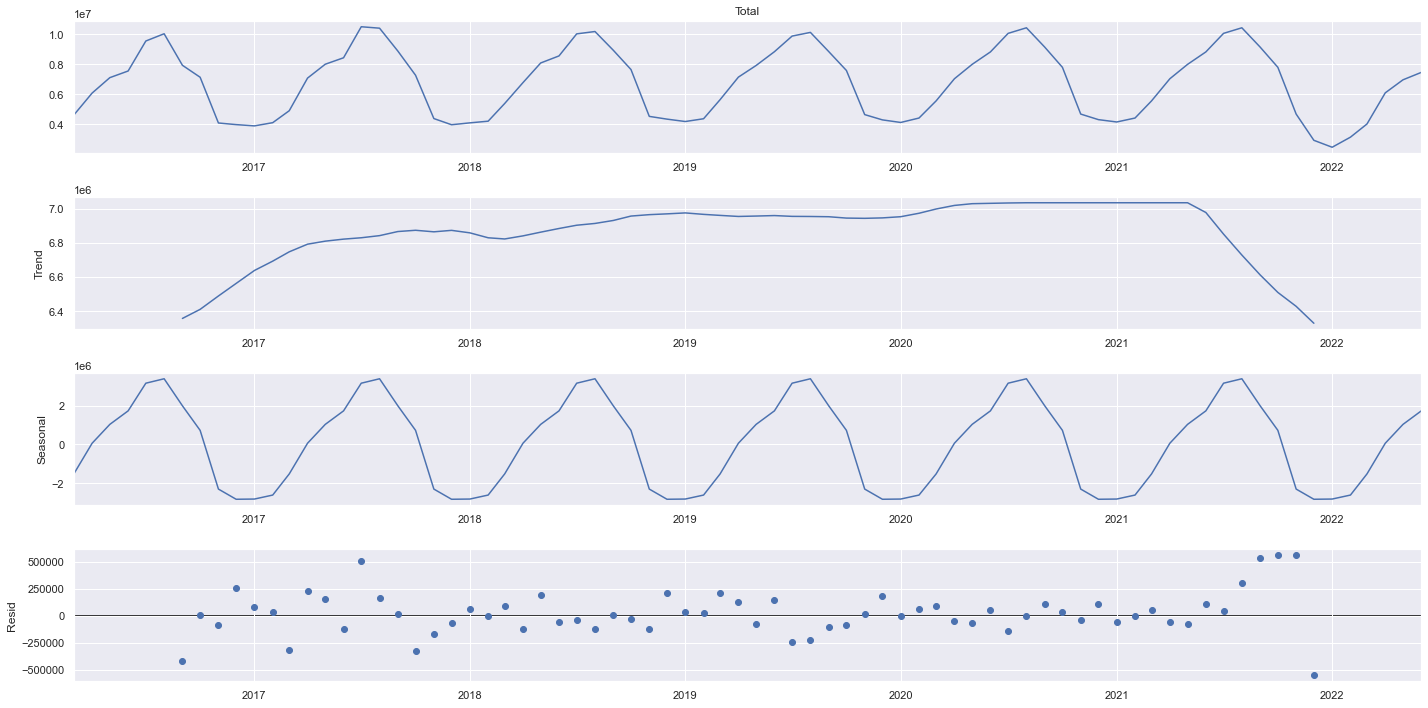

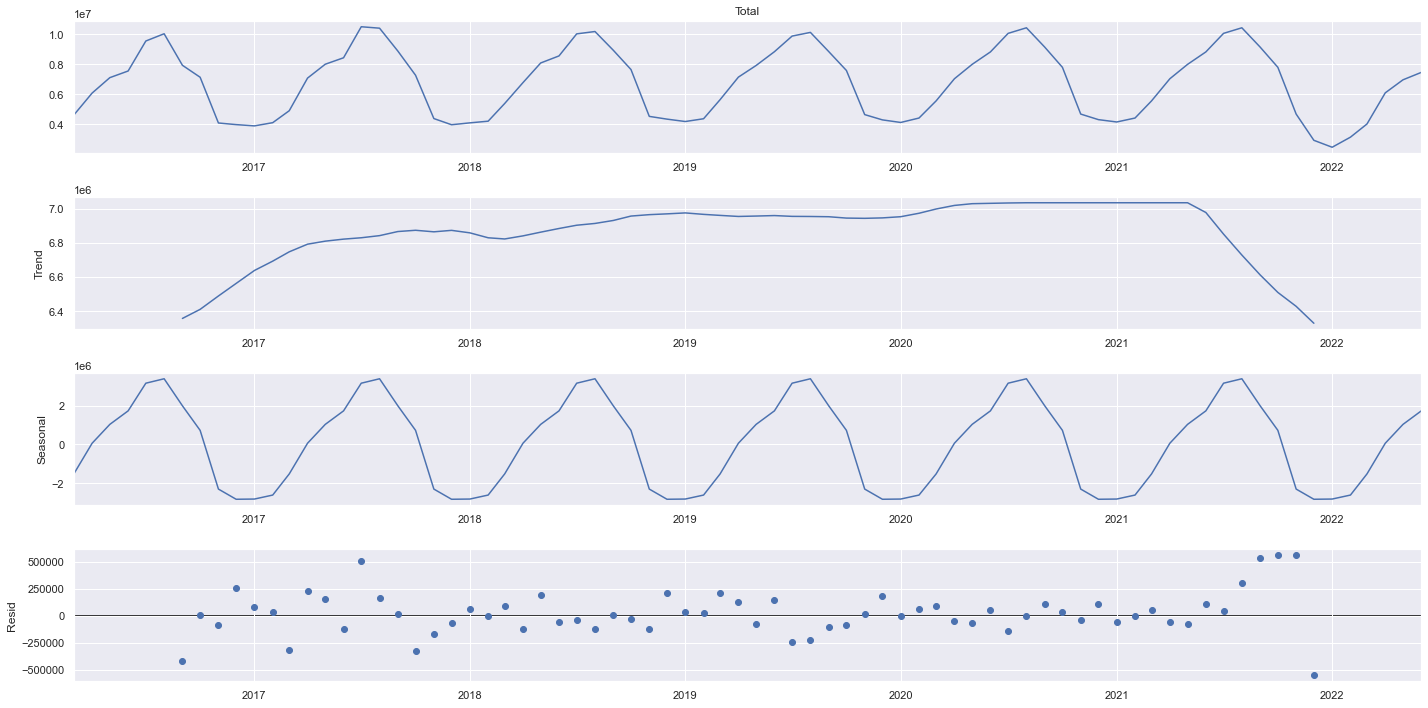

In [49]:
desglose=seasonal_decompose(df_turismo_new, 
                                   model='additive', 
                                   period=12);
desglose.plot()
# plt.savefig('../pics/df_paro_new/decompose.png');

Analizando las gráficas una vez intervenida la serie, observamos:

- Que existe una **tendencia creciente en todo momento hasta el final**.
- Que la serie **no es estacionaria**, aunque no es consistente del todo esa negación.
- Hay **componente estacional**.


## *4) Estimación mediante modelos*



### 4.1) Modelo de Suavizado Exponencial (ETS)

Cantidad de períodos en Train: 48
Cantidad de períodos en Test: 28


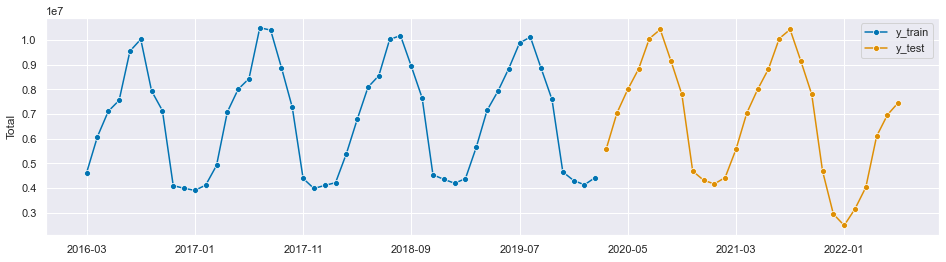

In [53]:
#Train-test
y_train,y_test_ets=temporal_train_test_split(
    y=df_turismo_new.astype('float64').to_period('M').sort_index(),test_size=28
)
# Grafico para representar la separación de los datos
plot_series(y_train, y_test_ets, labels=["y_train","y_test"])
print('Cantidad de períodos en Train:', y_train.shape[0])
print('Cantidad de períodos en Test:', y_test_ets.shape[0])
plt.show()

In [54]:
y_test_ets

2020-03     5567266.0
2020-04     7037309.0
2020-05     7993545.0
2020-06     8820595.0
2020-07    10054132.0
2020-08    10423836.0
2020-09     9140573.0
2020-10     7796987.0
2020-11     4690515.0
2020-12     4320861.0
2021-01     4165017.0
2021-02     4427339.0
2021-03     5567266.0
2021-04     7037309.0
2021-05     7993545.0
2021-06     8820595.0
2021-07    10054132.0
2021-08    10423836.0
2021-09     9140573.0
2021-10     7796987.0
2021-11     4690515.0
2021-12     2947525.0
2022-01     2486486.0
2022-02     3156809.0
2022-03     4032127.0
2022-04     6102142.0
2022-05     6966913.0
2022-06     7460277.0
Freq: M, Name: Total, dtype: float64

In [55]:
# Especifico la cantidad de períodos a estimar para obtener las observaciones predichas en test.
fh = np.arange(1, y_test_ets.shape[0]+1)

# Selecciono el modelo y sus parámetros de predicción, al igual que los recursos a utilizar para entrenar
turismonew_auto_ets = AutoETS(auto=True, sp=12, n_jobs=-1)
turismonew_auto_ets.fit(y_train)

AutoETS(auto=True, n_jobs=-1, sp=12)

In [56]:
#step 5: querying predictions
turismonew_pred = turismonew_auto_ets.predict(fh=list(fh))
(turismonew_pred.round()).tail()

2022-02    4427339.0
2022-03    5567266.0
2022-04    7037309.0
2022-05    7993545.0
2022-06    8820595.0
Freq: M, dtype: float64

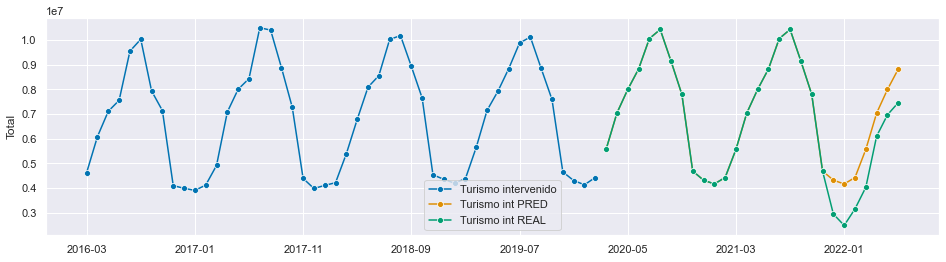

In [57]:
# optional: plotting predictions and past data
plot_series(y_train, turismonew_pred, y_test_ets, labels=["Turismo intervenido", 
                                                          "Turismo int PRED", 
                                                          "Turismo int REAL"])
plt.show()

In [58]:
mse = MeanSquaredError(square_root=True)
mse_ets = mse(y_test_ets, turismonew_pred)
print('El modelo ETS genera un RMSE de:', round(mse_ets,2))

El modelo ETS genera un RMSE de: 666906.37


In [59]:
mape = MeanAbsolutePercentageError(symmetric=False)
mape_ets = mape(y_test_ets, turismonew_pred)
print('El modelo ETS genera un MAPE de: {}%'.format(round(mape_ets*100,2)))

El modelo ETS genera un MAPE de: 8.6%


El modelo tiene un error pequeño y predice extremadamente bien. 

### 4.2) Modelo ARIMA

Al tratarse de una serie no estacionaria en media ni en varianza, debemos transformar a la serie para tener un correcto tratamiento de la misma y de esta manera, obtener las mejores predicciones posibles con el método de estimacion ARIMA.

Es necesario lograr que la serie sea estacionaria en varianza, luego el algoritmo es capaz de interpretar datos no estacionarios en media. Para ello, aplicaremos logaritmo y luego lo ploteamos para evidenciar si se ha logrado el objetivo.

In [86]:
transformer = LogTransformer()
log_df_turismo= transformer.fit_transform(df_turismo_new)
log_df_turismo.tail()

Periodo
2022-02-01    14.965072
2022-03-01    15.209805
2022-04-01    15.624150
2022-05-01    15.756683
2022-06-01    15.825103
dtype: float64

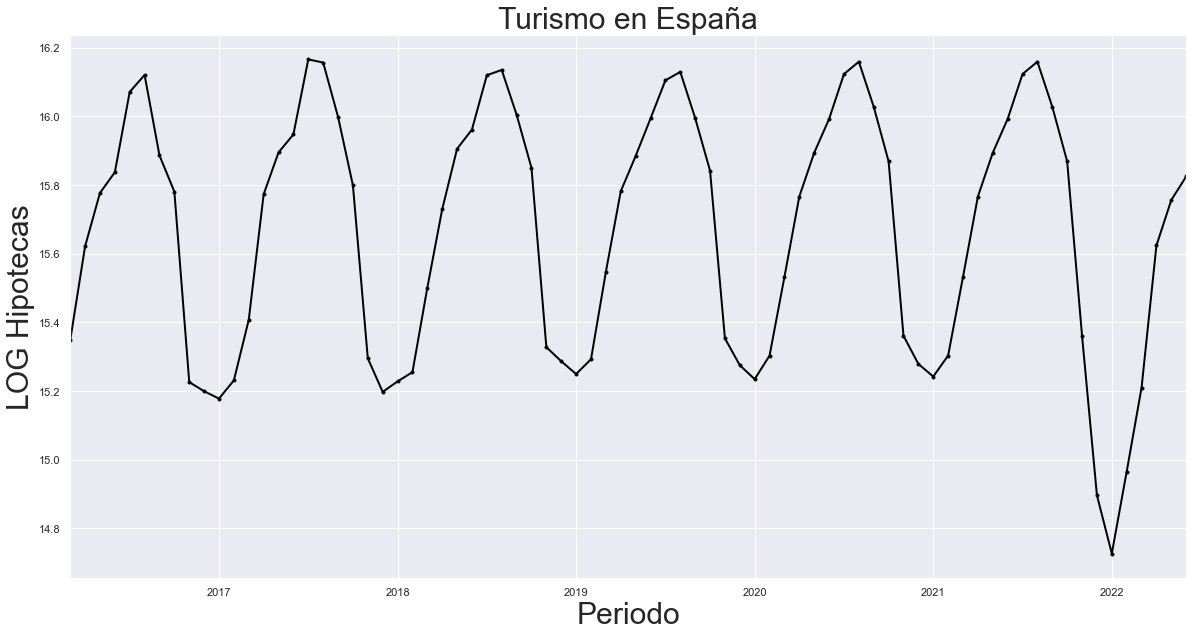

In [87]:
sns.set(rc={'figure.figsize':(20, 10)})
fig = log_df_turismo.plot(marker='.', color = 'black', linewidth= 2) 
fig.set_title('Turismo en España', fontsize = 30) 
fig.set_ylabel('LOG Hipotecas', fontsize = 30)
fig.set_xlabel('Periodo', fontsize = 30);

Separamos el train y test a la serie transformada en logs:

48 28


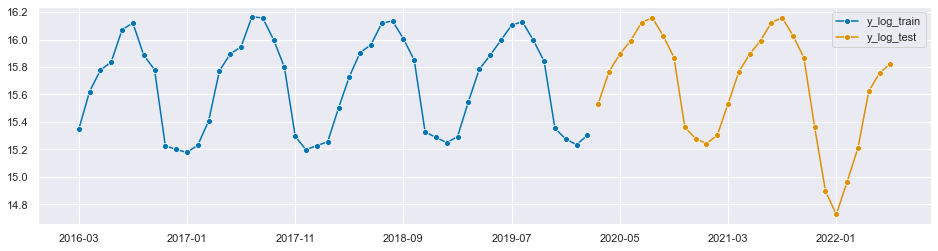

In [88]:
y_log_train,y_log_test=temporal_train_test_split(
    y=log_df_turismo.astype('float64').to_period('M').sort_index(),test_size=28)
plot_series(y_log_train, y_log_test, labels=["y_log_train", "y_log_test"])
print(y_log_train.shape[0], y_log_test.shape[0])
plt.show()

Generamos el modelo y se entrena con los datos del train:

In [92]:
fh = np.arange(1,y_log_test.shape[0]+1)
turismo_auto_arima=AutoARIMA(d=1,D=1,sp=12,suppress_warnings=True)

In [93]:
turismo_auto_arima.fit(y_log_train)
turismo_auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   48
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                  63.902
Date:                            Thu, 01 Sep 2022   AIC                           -123.805
Time:                                    00:13:47   BIC                           -120.694
Sample:                                         0   HQIC                          -122.731
                                             - 48                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6819      0.143     -4.760      0.000      -0.963      -0.401
sigma2         0.0015      0.000      3.187      0.001       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):                 0.66
Prob(Q):                              0.68   Prob(JB):                         0.72
Heteroskedasticity (H):               0.47   Skew:                            -0.13
Prob(H) (two-sided):                  0.20   Kurtosis:                         2.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [96]:
turismo_log_pred = turismo_auto_arima.predict(fh)
np.exp(turismo_log_pred).round()

2020-03     5610898.0
2020-04     7182335.0
2020-05     7894909.0
2020-06     8855809.0
2020-07     9860375.0
2020-08    10131263.0
2020-09     8840855.0
2020-10     7593169.0
2020-11     4654536.0
2020-12     4306695.0
2021-01     4133327.0
2021-02     4428817.0
2021-03     5611772.0
2021-04     7184321.0
2021-05     7896442.0
2021-06     8858026.0
2021-07     9862465.0
2021-08    10133676.0
2021-09     8842803.0
2021-10     7594934.0
2021-11     4655579.0
2021-12     4307684.0
2022-01     4134261.0
2022-02     4429830.0
2022-03     5613045.0
2022-04     7185959.0
2022-05     7898236.0
2022-06     8860043.0
Freq: M, dtype: float64

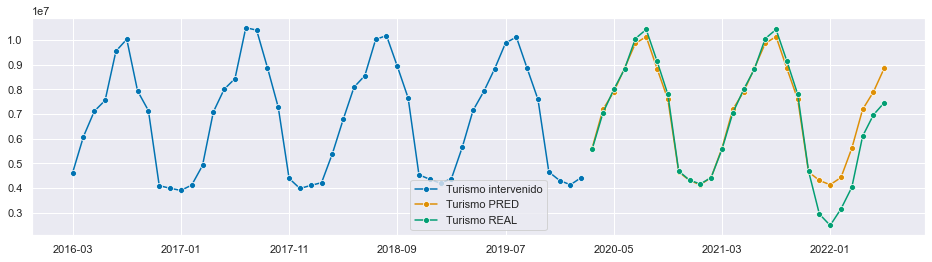

In [97]:
# representamos la serie predictiva
plot_series(np.exp(y_log_train), np.exp(turismo_log_pred), np.exp(y_log_test), 
            labels=["Turismo intervenido", "Turismo PRED", "Turismo REAL"])
plt.show()

In [98]:
mse = MeanSquaredError(square_root=True)
mse_log = mse(np.exp(y_log_test), np.exp(turismo_log_pred))
print('El modelo ARIMA genera un RMSE de:', round(mse_log,2))

El modelo ARIMA genera un RMSE de: 688254.35


In [99]:
mape = MeanAbsolutePercentageError(symmetric=False)
mape_log = mape(np.exp(y_log_test), np.exp(turismo_log_pred))
print('El modelo ARIMA genera un MAPE de: {}%'.format(round(mape_log*100,2)))

El modelo ARIMA genera un MAPE de: 9.81%


#### Una comparativa entre ETS y ARIMA

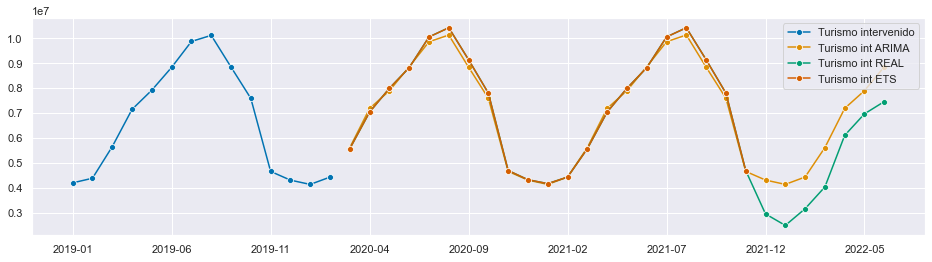

In [100]:
plot_series(np.exp(y_log_train["2019":]), np.exp(turismo_log_pred), np.exp(y_log_test), turismo_pred, 
            labels=["Turismo intervenido", "Turismo int ARIMA", "Turismo int REAL", 'Turismo int ETS'])
plt.show()
# plt.savefig('../pics/df_hipotecas/etsarima.png')

Ahora comparamos entre las métricas de error que tenemos:
1) RMSE (Error dependiente de la escala)

In [101]:
print('El modelo ETS genera un RMSE de:', round(mse_ets,2))
print('El modelo ARIMA genera un RMSE de:', round(mse_log,2))

El modelo ETS genera un RMSE de: 666906.37
El modelo ARIMA genera un RMSE de: 688254.35


In [102]:
print('El modelo ETS genera un MAPE de: {}%'.format(round(mape_ets*100,2)))
print('El modelo ARIMA genera un MAPE de {}%'.format(round(mape_log*100,2)))

El modelo ETS genera un MAPE de: 8.6%
El modelo ARIMA genera un MAPE de 9.81%


Aquí el mejor modelo es **ETS**, que da menos error. Ahora probamos con Prophet.

### 4.3) Prophet

FB Prophet es un modelo muy extendido para la predicción de series temporales desarrollado por Facebook. El objetivo de este paquete es dar a los usuarios una herramienta potente y de fácil uso para predecir resultados de distintas series temporales. Este modelo alcanza sus mejores resultados con series estacionarias o series con una tendencia y estacionalidad marcadas, como es el caso del turismo en España. Suele ser peor cuando aumenta la aleatoria de la muestra. 

Dentro de nuestro DataFrame cambiamos el nombre de la columna temporal *'Periodo'* y la de la variable objetivo *'Total'* por *'ds'* e *'y'*, y también quitamos el Periodo como índice, pues todos estos cambios son necesarios para que el modelo funcione bien.

In [103]:
prophet_train = df_turismo_new.reset_index() #cambiamos de índice
prophet_train.columns = ['ds', 'y'] #renombramos las columnas

In [104]:
prophet_y_train = y_train.copy()
prophet_y_train = prophet_y_train.rename_axis('index').reset_index()
prophet_y_train.columns = ['ds', 'y']
prophet_y_train['ds'] = prophet_y_train['ds'].dt.to_timestamp(freq = 'M')
len(prophet_y_train)

48

In [105]:
prophet_y_test = y_test.copy()
prophet_y_test = prophet_y_test.rename_axis('index').reset_index()
prophet_y_test.columns = ['ds', 'y']
prophet_y_test['ds'] = prophet_y_test['ds'].dt.to_timestamp(freq = 'M')
len(prophet_y_test)

20

In [106]:
prophet_y_train.tail()

,ds,y
43,2019-10-31,7587749.0
44,2019-11-30,4655021.0
45,2019-12-31,4304741.0
46,2020-01-31,4133024.0
47,2020-02-29,4427344.0


In [107]:
prophet_y_test.head()

,ds,y
0,2018-07-31,10020246.0
1,2018-08-31,10175761.0
2,2018-09-30,8932308.0
3,2018-10-31,7649860.0
4,2018-11-30,4536873.0


In [108]:
m = Prophet()
m.fit(prophet_y_train)

00:16:18 - cmdstanpy - INFO - Chain [1] start processing
00:16:19 - cmdstanpy - INFO - Chain [1] done processing


In [109]:
m_pred = m.make_future_dataframe(periods=len(prophet_y_test), freq='M')
prophet_forecast = m.predict(m_pred)

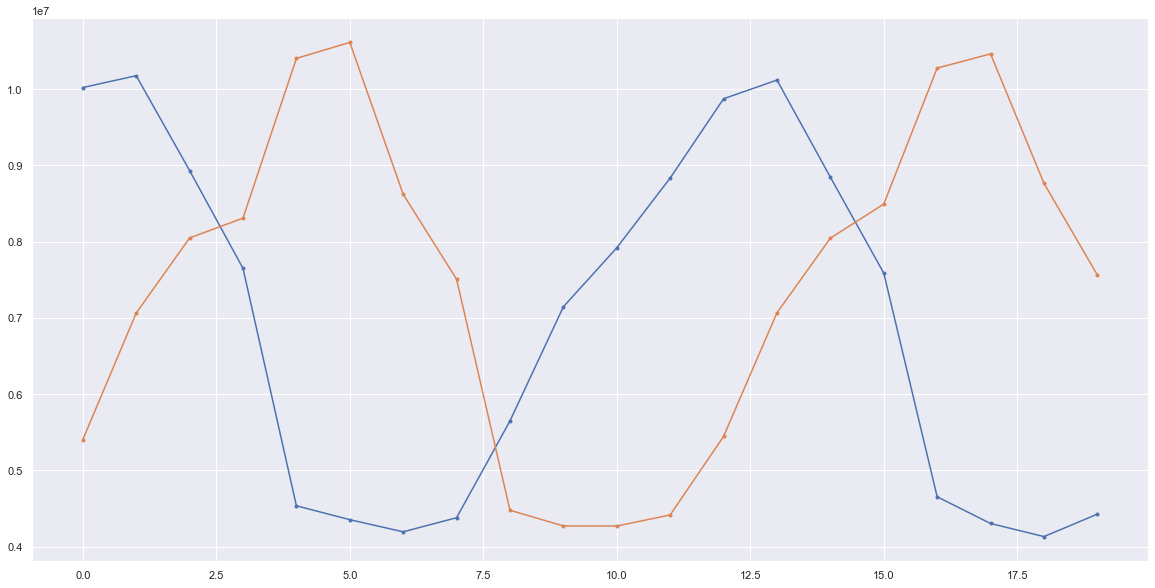

In [110]:
plt.plot(list(prophet_y_test['y']), '.-')
plt.plot(list(prophet_forecast.loc[48:, 'yhat']), '.-', label='Predicition')
plt.show()
# plt.savefig('../pics/df_paro_new/prophet.png')

In [111]:
# Forecast Accuracy
# MAPE
# mape_prophet = mean_absolute_percentage_error(prophet_y_test['y'], prophet_forecast.loc[47:, 'yhat'])
# mape_prophet

mape = MeanAbsolutePercentageError(symmetric=False)
mape_prophet = mape(prophet_y_test['y'], prophet_forecast.loc[48:, 'yhat'])
print('El modelo Prophet genera un MAPE de: {}%'.format(round(mape_prophet*100,2)))

El modelo Prophet genera un MAPE de: 62.23%


In [112]:
# Forecast Accuracy
#Mean Squared Error
mse = MeanSquaredError(square_root=True)
mse_prophet = mse(prophet_y_test['y'],prophet_forecast.loc[48:, 'yhat'])
print('El modelo Prophet genera un RMSE de:', round(mse_prophet,2))

El modelo Prophet genera un RMSE de: 3928897.92


In [113]:
prophet_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].round().tail()

,ds,yhat,yhat_lower,yhat_upper
63,2021-06-30,8492480.0,8303420.0,8674281.0
64,2021-07-31,10275348.0,10093419.0,10467740.0
65,2021-08-31,10461482.0,10263698.0,10650479.0
66,2021-09-30,8765636.0,8578194.0,8963566.0
67,2021-10-31,7563196.0,7354789.0,7775823.0


### 4.4) Comparativa errores y elección del mejor modelo

Ahora comparamos entre las métricas de error que tenemos:
1) RMSE (Error dependiente de la escala)

In [114]:
print('El modelo ETS genera un RMSE de:', round(mse_ets,2))
print('El modelo ARIMA genera un RMSE de:', round(mse_log,2))
print('El modelo Prophet genera un RMSE de:', round(mse_prophet,2))

El modelo ETS genera un RMSE de: 666906.37
El modelo ARIMA genera un RMSE de: 688254.35
El modelo Prophet genera un RMSE de: 3928897.92


2) MAPE (Error porcentual)

In [115]:
print('El modelo ETS genera un MAPE de: {}%'.format(round(mape_ets*100,2)))
print('El modelo ARIMA genera un MAPE de {}%'.format(round(mape_log*100,2)))
print('El modelo Prophet genera un MAPE de {}%'.format(round(mape_prophet*100,2)))

El modelo ETS genera un MAPE de: 8.6%
El modelo ARIMA genera un MAPE de 9.81%
El modelo Prophet genera un MAPE de 62.23%


Confirmamos que **el mejor modelo para la predicción de esta serie temporal es el ETS**, ya que es el que mejor se ajusta a los datos reales y es el que menor error da.

## *5) Predicción hasta finales de año*

A continuación realizamos la predicción de la serie temporal del desempleo intervenido hasta finales de año, es decir, hasta diciembre del 2022. 

In [120]:
# Especifico la cantidad de períodos a estimar para obtener las observaciones predichas en test.
fh = np.arange(1, 7)

# Selecciono el modelo y sus parámetros de predicción, al igual que los recursos a utilizar para entrenar
autoets_predict = AutoETS(auto=True, sp=12, n_jobs=-1)
y = df_turismo_new.astype('float64').to_period('M')
autoets_predict.fit(y)

AutoETS(auto=True, n_jobs=-1, sp=12)

In [121]:
print(autoets_predict.summary())

                                 ETS Results                                  
Dep. Variable:                  Total   No. Observations:                   76
Model:                       ETS(MNM)   Log Likelihood               -1089.485
Date:                Thu, 01 Sep 2022   AIC                           2210.971
Time:                        00:17:55   BIC                           2248.263
Sample:                    03-31-2016   HQIC                          2225.875
                         - 06-30-2022   Scale                            0.004
Covariance Type:               approx                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.9999      0.075     13.310      0.000       0.853       1.147
smoothing_seasonal   9.935e-05        nan        nan        nan         nan         nan
initial_level   

In [122]:
# Predicción del desempleo para los próximos 6 meses:
turismonew_pred = autoets_predict.predict(fh=list(fh))
turismonew_pred.round()

2022-07    8777526.0
2022-08    8965844.0
2022-09    7670754.0
2022-10    6544311.0
2022-11    3896953.0
2022-12    3495512.0
Freq: M, dtype: float64

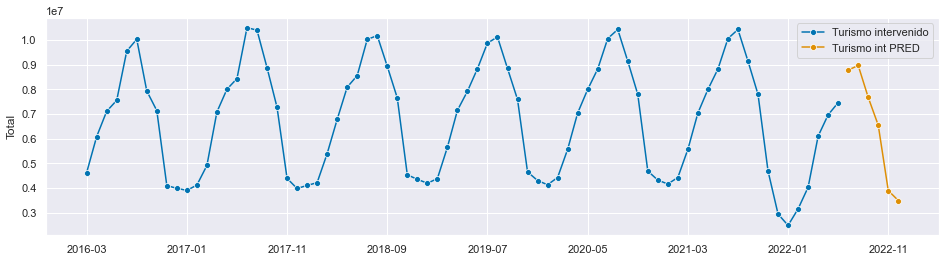

In [123]:
# Representamos gráficamente:
plot_series(y, turismonew_pred, labels=["Turismo intervenido", "Turismo int PRED"])
plt.show()
# plt.savefig('../pics/df_paro_new/predict2022.png')